In [1]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')
#
# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment2/'
# FOLDERNAME = 'Masters_Project/data_processing'
# assert FOLDERNAME is not None, "[!] Enter the foldername."
#
# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
#

In [2]:
# Load triggers data

import numpy as np 
from sklearn.model_selection import train_test_split

triggers = np.load("./triggers_data.npz")

Xraw = []
yraw = []
for i, key in enumerate(triggers):
    sig = triggers[key]
    Xraw.append(sig)
    yraw.append(np.full(len(sig), i))

Xraw = np.concatenate(Xraw)
yraw = np.concatenate(yraw)
Xraw.shape

(177, 30)

In [3]:
# Split data into test  and train set
Xtrain, Xtest, ytrain, ytest = train_test_split(Xraw, yraw, test_size=0.1, random_state=42)
print("Fraction of single class in test set: ", np.mean(ytest==0))
print("Size of test set:", Xtest.shape)

# Split train data into train and validation set
Xfold, Xval, yfold, yval = train_test_split(Xtrain, ytrain, test_size=0.1, random_state=42)
print("Size of train set:", Xtrain.shape)

Fraction of single class in test set:  0.5
Size of test set: (18, 30)
Size of train set: (159, 30)


In [4]:
# Function to print accuracy of validation set while training
def checkAcc(x, y, model, set="Validation"):
    scores = model(x)
    _, preds = scores.max(1)
    num_correct = (preds == y).sum()
    num_samples = preds.size(0)
    acc = float(num_correct) / num_samples
    print(f"{set} Accuracy: {num_correct} / {num_samples} = {acc:.2f}")

In [5]:
# Try to code a simple network
import torch

device = torch.device('cpu')
dtype = torch.float32

N, D_in, H, D_out = len(Xtrain), 30, 1000, 2 

# Create random Tensors to hold inputs and outputs
x = torch.tensor(Xfold, device=device, dtype=dtype)
y = torch.tensor(yfold, device=device, dtype=torch.long)

xv = torch.tensor(Xval, device=device, dtype=dtype)
yv = torch.tensor(yval, device=device, dtype=torch.long)

0 0.6952245831489563
Validation Accuracy: 7 / 16 = 0.44
100 0.6844682097434998
Validation Accuracy: 11 / 16 = 0.69
200 0.6806141138076782
Validation Accuracy: 11 / 16 = 0.69
300 0.6768592596054077
Validation Accuracy: 11 / 16 = 0.69
400 0.6731920838356018
Validation Accuracy: 12 / 16 = 0.75
500 0.6696192622184753
Validation Accuracy: 13 / 16 = 0.81
600 0.6661348938941956
Validation Accuracy: 13 / 16 = 0.81
700 0.662723183631897
Validation Accuracy: 13 / 16 = 0.81
800 0.6593934893608093
Validation Accuracy: 13 / 16 = 0.81
900 0.6561447978019714
Validation Accuracy: 13 / 16 = 0.81
1000 0.6529660820960999
Validation Accuracy: 14 / 16 = 0.88
1100 0.649864137172699
Validation Accuracy: 14 / 16 = 0.88
1200 0.6468313336372375
Validation Accuracy: 14 / 16 = 0.88
1300 0.6438839435577393
Validation Accuracy: 14 / 16 = 0.88
1400 0.6410225033760071
Validation Accuracy: 14 / 16 = 0.88
1500 0.6382311582565308
Validation Accuracy: 14 / 16 = 0.88
1600 0.6355107426643372
Validation Accuracy: 14 / 16 = 

In [ ]:
# Define a general procedure to train a model

def trainModel(model, loss_fn, optimizer, x, y, xv, yv, N=2000):
# learning_rate = 1e-4
    for t in range(N):

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # Internally, this call will compute gradients for all learnable parameters in the model.
        loss.backward()

        # Update weights
        optimizer.step()
        # Zero the gradients after weight updates.
        optimizer.zero_grad()

        with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
            if t%100==0:
                print(f"Iteration {t}\nLoss: {loss.item()}")
                checkAcc(xv, yv, model)

In [ ]:
# Create a simple architecture first
# Use nn.Sequention API 
# Each layer has its own internal weights and bias 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        ).to(device)

# Loss function to use - check available functions on pytorch
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

trainModel(model, loss_fn, optimizer, x, y, xv, yv)

In [6]:
# Test model on test data
xt= torch.tensor(Xtest, device=device, dtype=dtype)
yt= torch.tensor(ytest, device=device, dtype=torch.long)
with torch.no_grad():
    checkAcc(xt, yt, model, set="Test")

Test Accuracy: 15 / 18 = 0.83


In [7]:
# Normalizing the data and building a deeper layer model
def normalize(x, xtr):
    # Use quantities from training data set
    avgmax = np.mean(np.max(xtr, axis=1))
    return x / avgmax 

xdata = [Xfold, Xval, Xtest]
for i in range(len(xdata)):
    xdata[i] = normalize(xdata[i], Xfold)

# Pass onto pytorch tensors
for i in range(len(xdata)):
    xdata[i] = torch.tensor(xdata[i], device=device, dtype=dtype)

xnorm, xvnorm, xtnorm = xdata

class deepModel(torch.nn.Module):
    def __init__(self):
        super(deepModel, self).__init__()

        self.layer1 = torch.nn.Sequential(
                torch.nn.Conv1d(1, 10, kernel_size=3),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=2)
                )
        self.fc1 = torch.nn.Linear(15 * 10, 1000)
        self.fc2 = torch.nn.Linear(1000, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model_deep = deepModel()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

print("Same model but with normalized data:")
trainModel(model_deep, loss_fn, optimizer, xnorm, y, xvnorm, yv)
with torch.no_grad():
    checkAcc(xtnorm, yt, model, set="Test")

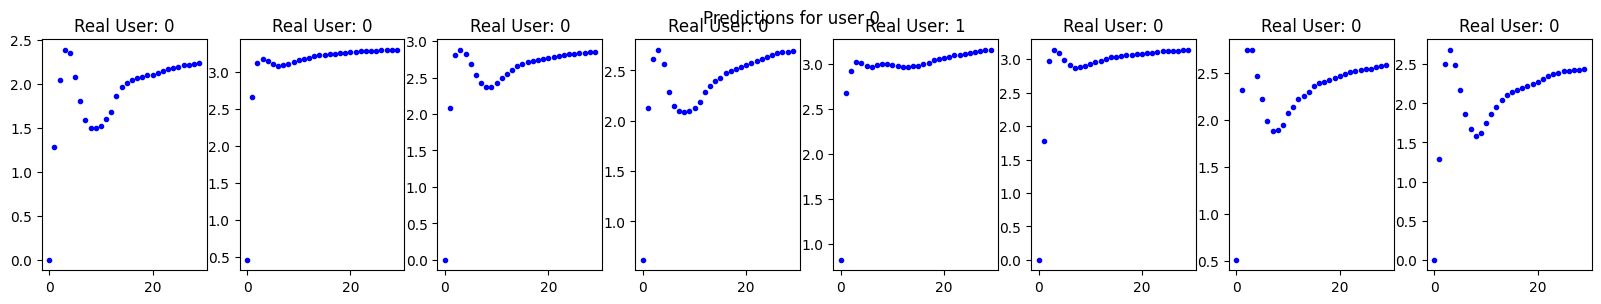

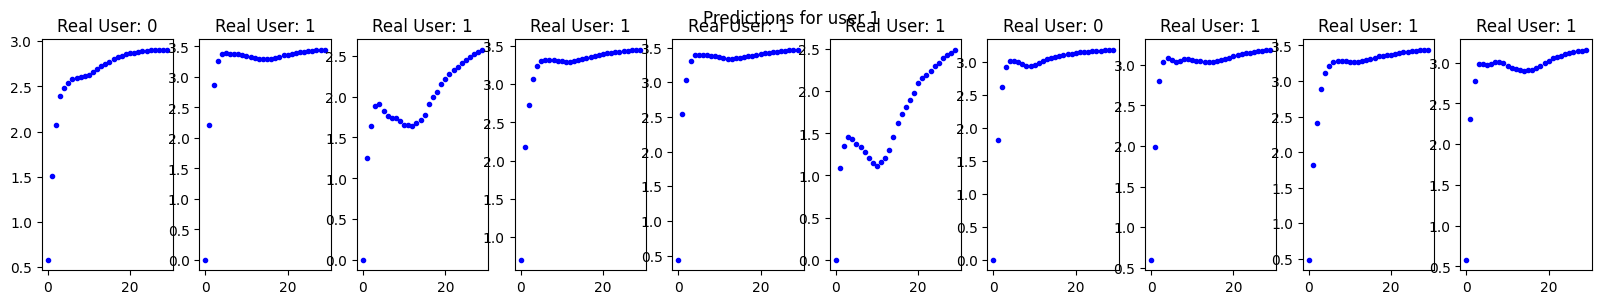

In [11]:
import matplotlib.pyplot as plt
# Plot results
with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
    scores = model(xt)
    _, preds = scores.max(1)
    predictions = preds.detach().numpy()

usr1 = predictions==0
usr2 = ~usr1

for j, usr in enumerate([usr1, usr2]):
    X1 = Xtest[usr]
    labels = ytest[usr]
    plt.figure(figsize=(20, 3))
    plt.suptitle(f"Predictions for user {j}")
    for i, (x, lab) in enumerate(zip(X1, labels)):
        plt.subplot(1, len(X1), i+1)
        plt.plot(range(len(x)), x, "b.")
        plt.title(f"Real User: {lab}")